In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import aligned_vae, vae
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dataset import *
import scipy
import math

In [59]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [60]:
atac = torch.FloatTensor(np.tile(np.arange(100), (100, 1)) + np.tile(np.arange(100)[:,None], 100))
rna = torch.FloatTensor(np.tile(np.arange(200), (100, 1)) + np.tile(np.arange(100)[:,None], 200))

In [61]:
atac

tensor([[  0.,   1.,   2.,  ...,  97.,  98.,  99.],
        [  1.,   2.,   3.,  ...,  98.,  99., 100.],
        [  2.,   3.,   4.,  ...,  99., 100., 101.],
        ...,
        [ 97.,  98.,  99.,  ..., 194., 195., 196.],
        [ 98.,  99., 100.,  ..., 195., 196., 197.],
        [ 99., 100., 101.,  ..., 196., 197., 198.]])

In [62]:
rna

tensor([[  0.,   1.,   2.,  ..., 197., 198., 199.],
        [  1.,   2.,   3.,  ..., 198., 199., 200.],
        [  2.,   3.,   4.,  ..., 199., 200., 201.],
        ...,
        [ 97.,  98.,  99.,  ..., 294., 295., 296.],
        [ 98.,  99., 100.,  ..., 295., 296., 297.],
        [ 99., 100., 101.,  ..., 296., 297., 298.]])

In [63]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    return dist 

# Similarity matrix
Note that for distance calculation, dimension reduction is necessary as raw data is too noisy
## Diffusion map distance

In [65]:
pca = PCA(n_components=30)

# atac_lsi = latent_semantic_indexing(atac, k = 30)
atac_pca = pca.fit_transform(atac)

rna_pca = pca.fit_transform(np.log1p(rna))

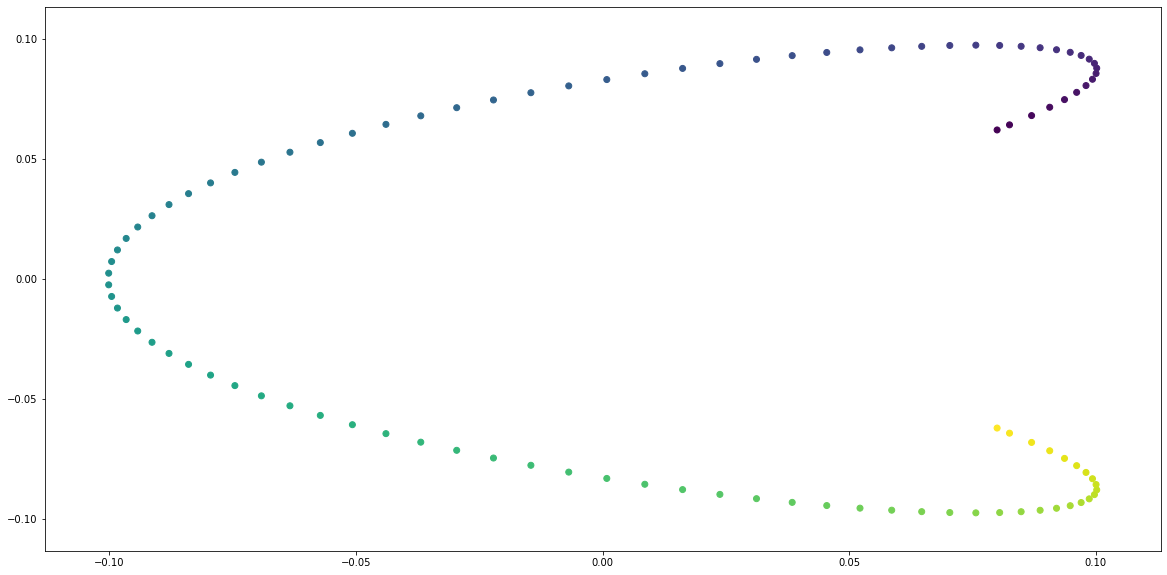

In [66]:
diffu_atac = diff.diffusion_map(atac_pca, n_eign = 10, alpha = 100, diffusion_time = 5)
diff_sim_atac = diff.diffusion_similarity(diffu_atac)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu_atac[:,2], diffu_atac[:,1], c=np.arange(atac.shape[0]))

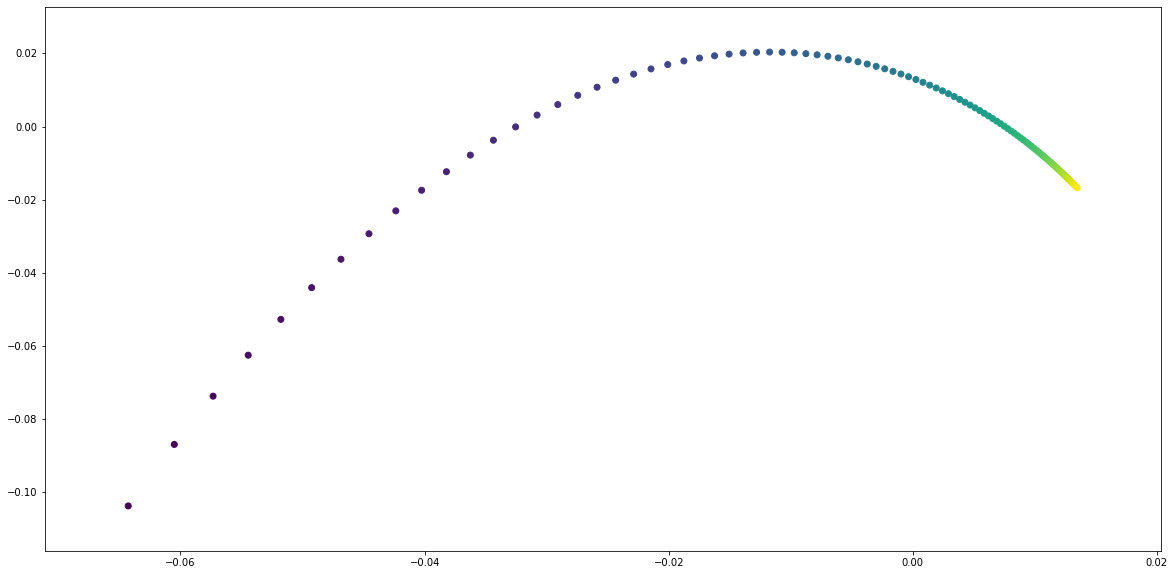

In [67]:
diffu = diff.diffusion_map(rna_pca, n_eign = 10, alpha = 15, diffusion_time = 5)
diff_sim_rna = diff.diffusion_similarity(diffu)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,1], diffu[:,2], c=np.arange(rna.shape[0]))


In [68]:
# normalize both matrices for inner product loss
diff_sim_atac = torch.FloatTensor(diff_sim_atac).to(device)
diff_sim_rna = torch.FloatTensor(diff_sim_rna).to(device)
diff_sim_atac = diff_sim_atac / torch.norm(diff_sim_atac, p = 'fro')
diff_sim_rna = diff_sim_rna / torch.norm(diff_sim_rna, p = 'fro')

In [69]:
# pca calculated internally, no need to do pca before
DPT_atac = diff.DPT_similarity(atac)
DPT_rna = diff.DPT_similarity(rna)

# normalize both matrices for inner product loss
DPT_atac = torch.FloatTensor(DPT_atac).to(device)
DPT_rna = torch.FloatTensor(DPT_rna).to(device)
DPT_atac = DPT_atac / torch.norm(DPT_atac, p = 'fro')
DPT_rna = DPT_rna / torch.norm(DPT_rna, p = 'fro')

In [70]:
def dist_loss(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, lamb, lamb_var, dist_loss_type = "cosine"):
    loss_recon_rna = F.mse_loss(recon_rna, rna)
    loss_recon_atac = F.mse_loss(recon_atac, atac)

    # loss_variance = - lamb_var * (torch.sum((z[:,0] - torch.mean(z[:,0])) ** 2) + torch.sum((z[:,1] - torch.mean(z[:,1])) ** 2))

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna

In [71]:
def train_ae(model, data_loader, lamb = 10, lamb_var = 0.1, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_var = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]

        loss = dist_loss(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, lamb = lamb, lamb_var = lamb_var, dist_loss_type= 'cosine')
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]

        current_loss = loss[1]
        current_loss.backward()
        optimizer.step()

    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_recon_atac.item() / len(data_loader), \
 total_loss_dist_rna.item() / len(data_loader), total_loss_dist_atac.item() / len(data_loader)

In [72]:
def test(model):
    data_loader_test = DataLoader(testset, batch_size=len(testset),shuffle=False)
    for data in data_loader_test:
        recon_atac, recon_rna, z = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
    z = z.detach().cpu().numpy()
    atac_loss = F.mse_loss(torch.FloatTensor(atac).to(device), recon_atac).item()
    rna_loss = F.mse_loss(torch.FloatTensor(rna).to(device), recon_rna).item()
    return z, atac_loss, rna_loss, recon_atac, recon_rna

## AutoEncoder
Diffusion map as similarity matrix

In [73]:
data_loader = DataLoader(testset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=32, latent_channels_rna=32, latent_channels_z=2, layer1_channels = 128, layer2_channels = 64).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-3, weight_decay=0.01)

for epoch in range(0, 301):

    loss, l1, l2, l3, l4 = train_ae(model_ae, data_loader, lamb = 100, similarity = "diffusion map")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4))

Epoch: 000, Total loss: nan, Recon RNA loss: 26260.25000, Recon ATAC loss 11419.37207, Dist RNA loss nan, Dist ATAC loss nan
Epoch: 010, Total loss: 12267.31348, Recon RNA loss: 868.36920, Recon ATAC loss 11434.07227, Dist RNA loss -17.28995, Dist ATAC loss -17.83735
Epoch: 020, Total loss: 11185.44824, Recon RNA loss: 145.58757, Recon ATAC loss 11074.94141, Dist RNA loss -17.06749, Dist ATAC loss -18.01287
Epoch: 030, Total loss: 11544.91504, Recon RNA loss: 139.17183, Recon ATAC loss 11440.89844, Dist RNA loss -17.24133, Dist ATAC loss -17.91241
Epoch: 040, Total loss: 11851.65430, Recon RNA loss: 114.31041, Recon ATAC loss 11772.46289, Dist RNA loss -16.99900, Dist ATAC loss -18.12065
Epoch: 050, Total loss: 11703.64258, Recon RNA loss: 100.41159, Recon ATAC loss 11637.73828, Dist RNA loss -17.02402, Dist ATAC loss -17.48290
Epoch: 060, Total loss: 11405.75781, Recon RNA loss: 109.89042, Recon ATAC loss 11330.49805, Dist RNA loss -17.13323, Dist ATAC loss -17.49664
Epoch: 070, Total

atac recon loss:11694.708984375rna recon loss105.4417495727539


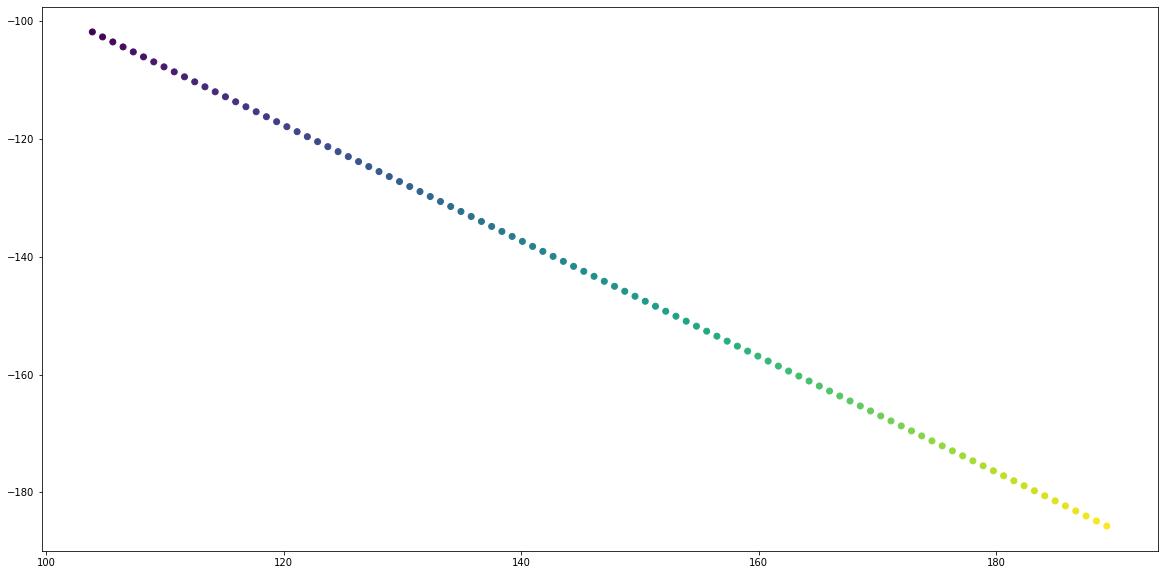

In [74]:
z, atac_loss, rna_loss, recon_atac, recon_rna = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
print("atac recon loss: ", atac_loss, "rna recon loss", rna_loss)

In [31]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(rna.detach().cpu().numpy(), recon_rna.detach().cpu().numpy()))
print(mean_squared_error(atac.detach().cpu().numpy(), recon_atac.detach().cpu().numpy()))

0.023991926
0.013482783


DPT as similarity matrix

In [28]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=16, latent_channels_rna=16, latent_channels_z=2, layer1_channels = 512, layer2_channels = 128).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 30):

    loss, l1, l2, l3, l4 = train_ae(model_ae, data_loader, lamb = 100, similarity = "DPT")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4))

RuntimeError: size mismatch, m1: [32 x 9467], m2: [100 x 512] at C:/w/1/s/tmp_conda_3.7_100118/conda/conda-bld/pytorch_1579082551706/work/aten/src\THC/generic/THCTensorMathBlas.cu:290

In [ ]:
z, l1, l2 = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
print("atac recon loss: ", l1, "rna recon loss", l2)

## Variational AutoEncoder

In [75]:
def dist_loss_kl(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, logvarz, muz, lamb, dist_loss_type = "cosine", beta=0.01):
    loss_recon_rna = F.mse_loss(rna, recon_rna)
    loss_recon_atac = F.mse_loss(atac, recon_atac)

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss_kl = beta * 0.5 * torch.sum(- logvarz + torch.exp(logvarz) + muz * muz - 1)

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna + loss_kl
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna, loss_kl

In [79]:
def train_vae(model, data_loader, lamb = 1, beta = 0.01, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_kl = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z, logvarz, muz = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]

        loss = dist_loss_kl(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, logvarz, muz, lamb = lamb, dist_loss_type= 'cosine', beta = beta)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]
        total_loss_kl += loss[5]

        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()
    
    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_recon_atac.item() / len(data_loader), \
 total_loss_dist_rna.item() / len(data_loader), total_loss_dist_atac.item() / len(data_loader), total_loss_kl / len(data_loader)

In [77]:
def test_vae(model):
    model.eval()
    
    data_loader_test = DataLoader(testset, batch_size=len(dataset),shuffle=False)
    for data in data_loader_test:
        recon_atac, recon_rna, z, logvarz, muz = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
    z = z.detach().cpu().numpy()
    muz = muz.detach().cpu().numpy()
    logvarz = logvarz.detach().cpu().numpy()
    atac_loss = F.mse_loss(torch.FloatTensor(atac).to(device), recon_atac).item()
    rna_loss = F.mse_loss(torch.FloatTensor(rna).to(device), recon_rna).item()

    return z, atac_loss, rna_loss, recon_atac, recon_rna, logvarz, muz

In [80]:
data_loader = DataLoader(testset, shuffle=True, batch_size=32)

model_vae = aligned_vae(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=32, latent_channels_rna=32, latent_channels_z=2, layer1_channels = 128, layer2_channels = 64).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-3, weight_decay=0.01)

for epoch in range(0, 601):

    loss, l1, l2, l3, l4, l5 = train_vae(model_vae, data_loader, lamb = 100, beta=0.001, similarity = "DPT")
    if epoch % 20 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}, KL loss: {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4, l5))

Epoch: 000, Total loss: 35370.89062, Recon RNA loss: 24914.11914, Recon ATAC loss 10481.19727, Dist RNA loss -12.24790, Dist ATAC loss -12.24790, KL loss: 0.07003
Epoch: 020, Total loss: 668.28345, Recon RNA loss: 196.38116, Recon ATAC loss 103.27951, Dist RNA loss -22.90471, Dist ATAC loss -22.90471, KL loss: 414.43219
Epoch: 040, Total loss: 423.73911, Recon RNA loss: 126.56974, Recon ATAC loss 108.52895, Dist RNA loss -22.77351, Dist ATAC loss -22.77351, KL loss: 234.18744
Epoch: 060, Total loss: 324.96478, Recon RNA loss: 125.04153, Recon ATAC loss 109.40636, Dist RNA loss -22.76374, Dist ATAC loss -22.76374, KL loss: 136.04437
Epoch: 080, Total loss: 273.77289, Recon RNA loss: 135.04630, Recon ATAC loss 100.45587, Dist RNA loss -21.73734, Dist ATAC loss -21.73734, KL loss: 81.74538
Epoch: 100, Total loss: 168.87030, Recon RNA loss: 107.76701, Recon ATAC loss 50.44656, Dist RNA loss -22.95099, Dist ATAC loss -22.95099, KL loss: 56.55869
Epoch: 120, Total loss: 8.88507, Recon RNA lo

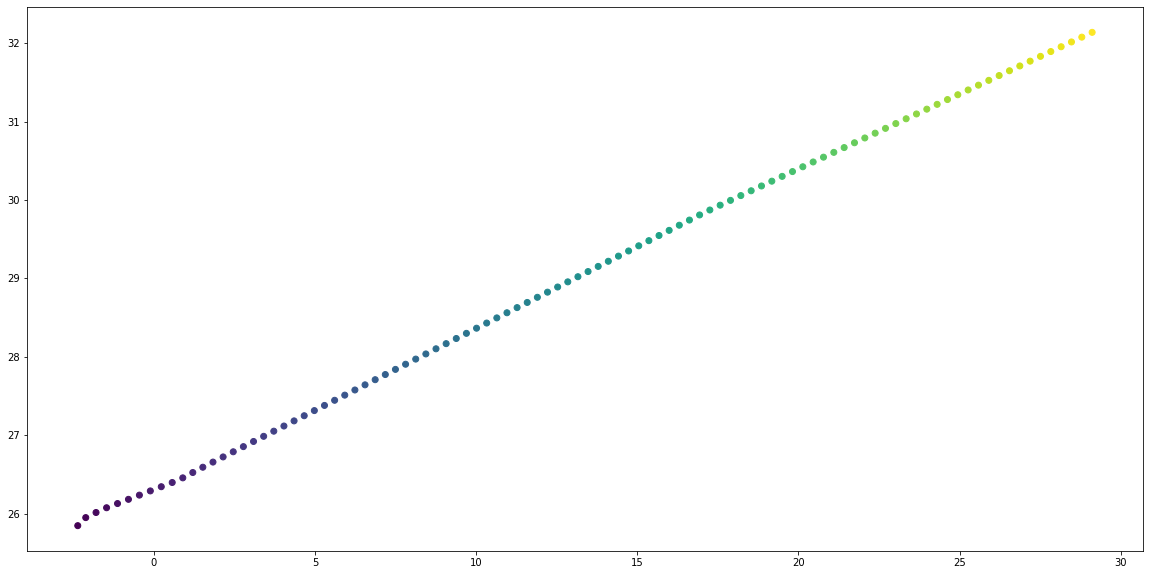

In [48]:
z, _, _, recon_atac, recon_rna, logvarz, muz = test_vae(model_vae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))

In [45]:
recon_atac

tensor([[ 25.8993,  25.9428,  27.0243,  ...,  78.6586,  79.1035,  79.7296],
        [ 26.3845,  26.4363,  27.5247,  ...,  79.8823,  80.3376,  80.9707],
        [ 26.8698,  26.9299,  28.0251,  ...,  81.1061,  81.5717,  82.2118],
        ...,
        [ 80.3118,  82.0994,  82.9066,  ..., 205.5835, 206.8827, 208.1917],
        [ 80.8779,  82.6840,  83.4878,  ..., 206.8979, 208.2059, 209.5219],
        [ 81.4439,  83.2686,  84.0690,  ..., 208.2124, 209.5291, 210.8521]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [46]:
recon_rna

tensor([[ 37.3300,  37.5124,  39.0224,  ..., 173.2305, 174.5700, 174.6720],
        [ 37.6783,  37.8786,  39.3792,  ..., 174.6526, 175.9918, 176.1074],
        [ 38.0266,  38.2447,  39.7360,  ..., 176.0747, 177.4136, 177.5428],
        ...,
        [ 70.8634,  72.7653,  73.3740,  ..., 310.1484, 311.4612, 312.8720],
        [ 71.2091,  73.1287,  73.7281,  ..., 311.5599, 312.8724, 314.2968],
        [ 71.5548,  73.4921,  74.0822,  ..., 312.9713, 314.2836, 315.7214]],
       device='cuda:0', grad_fn=<AddmmBackward>)